In [1]:
import numpy as np
import scipy.sparse as sps
import porepy as pp

import ddf.common as co
import ddf.hrl as hrl

from ddf.plot import quiver, plot_cells, streamplot, quiver2
from ddf.immagini import *

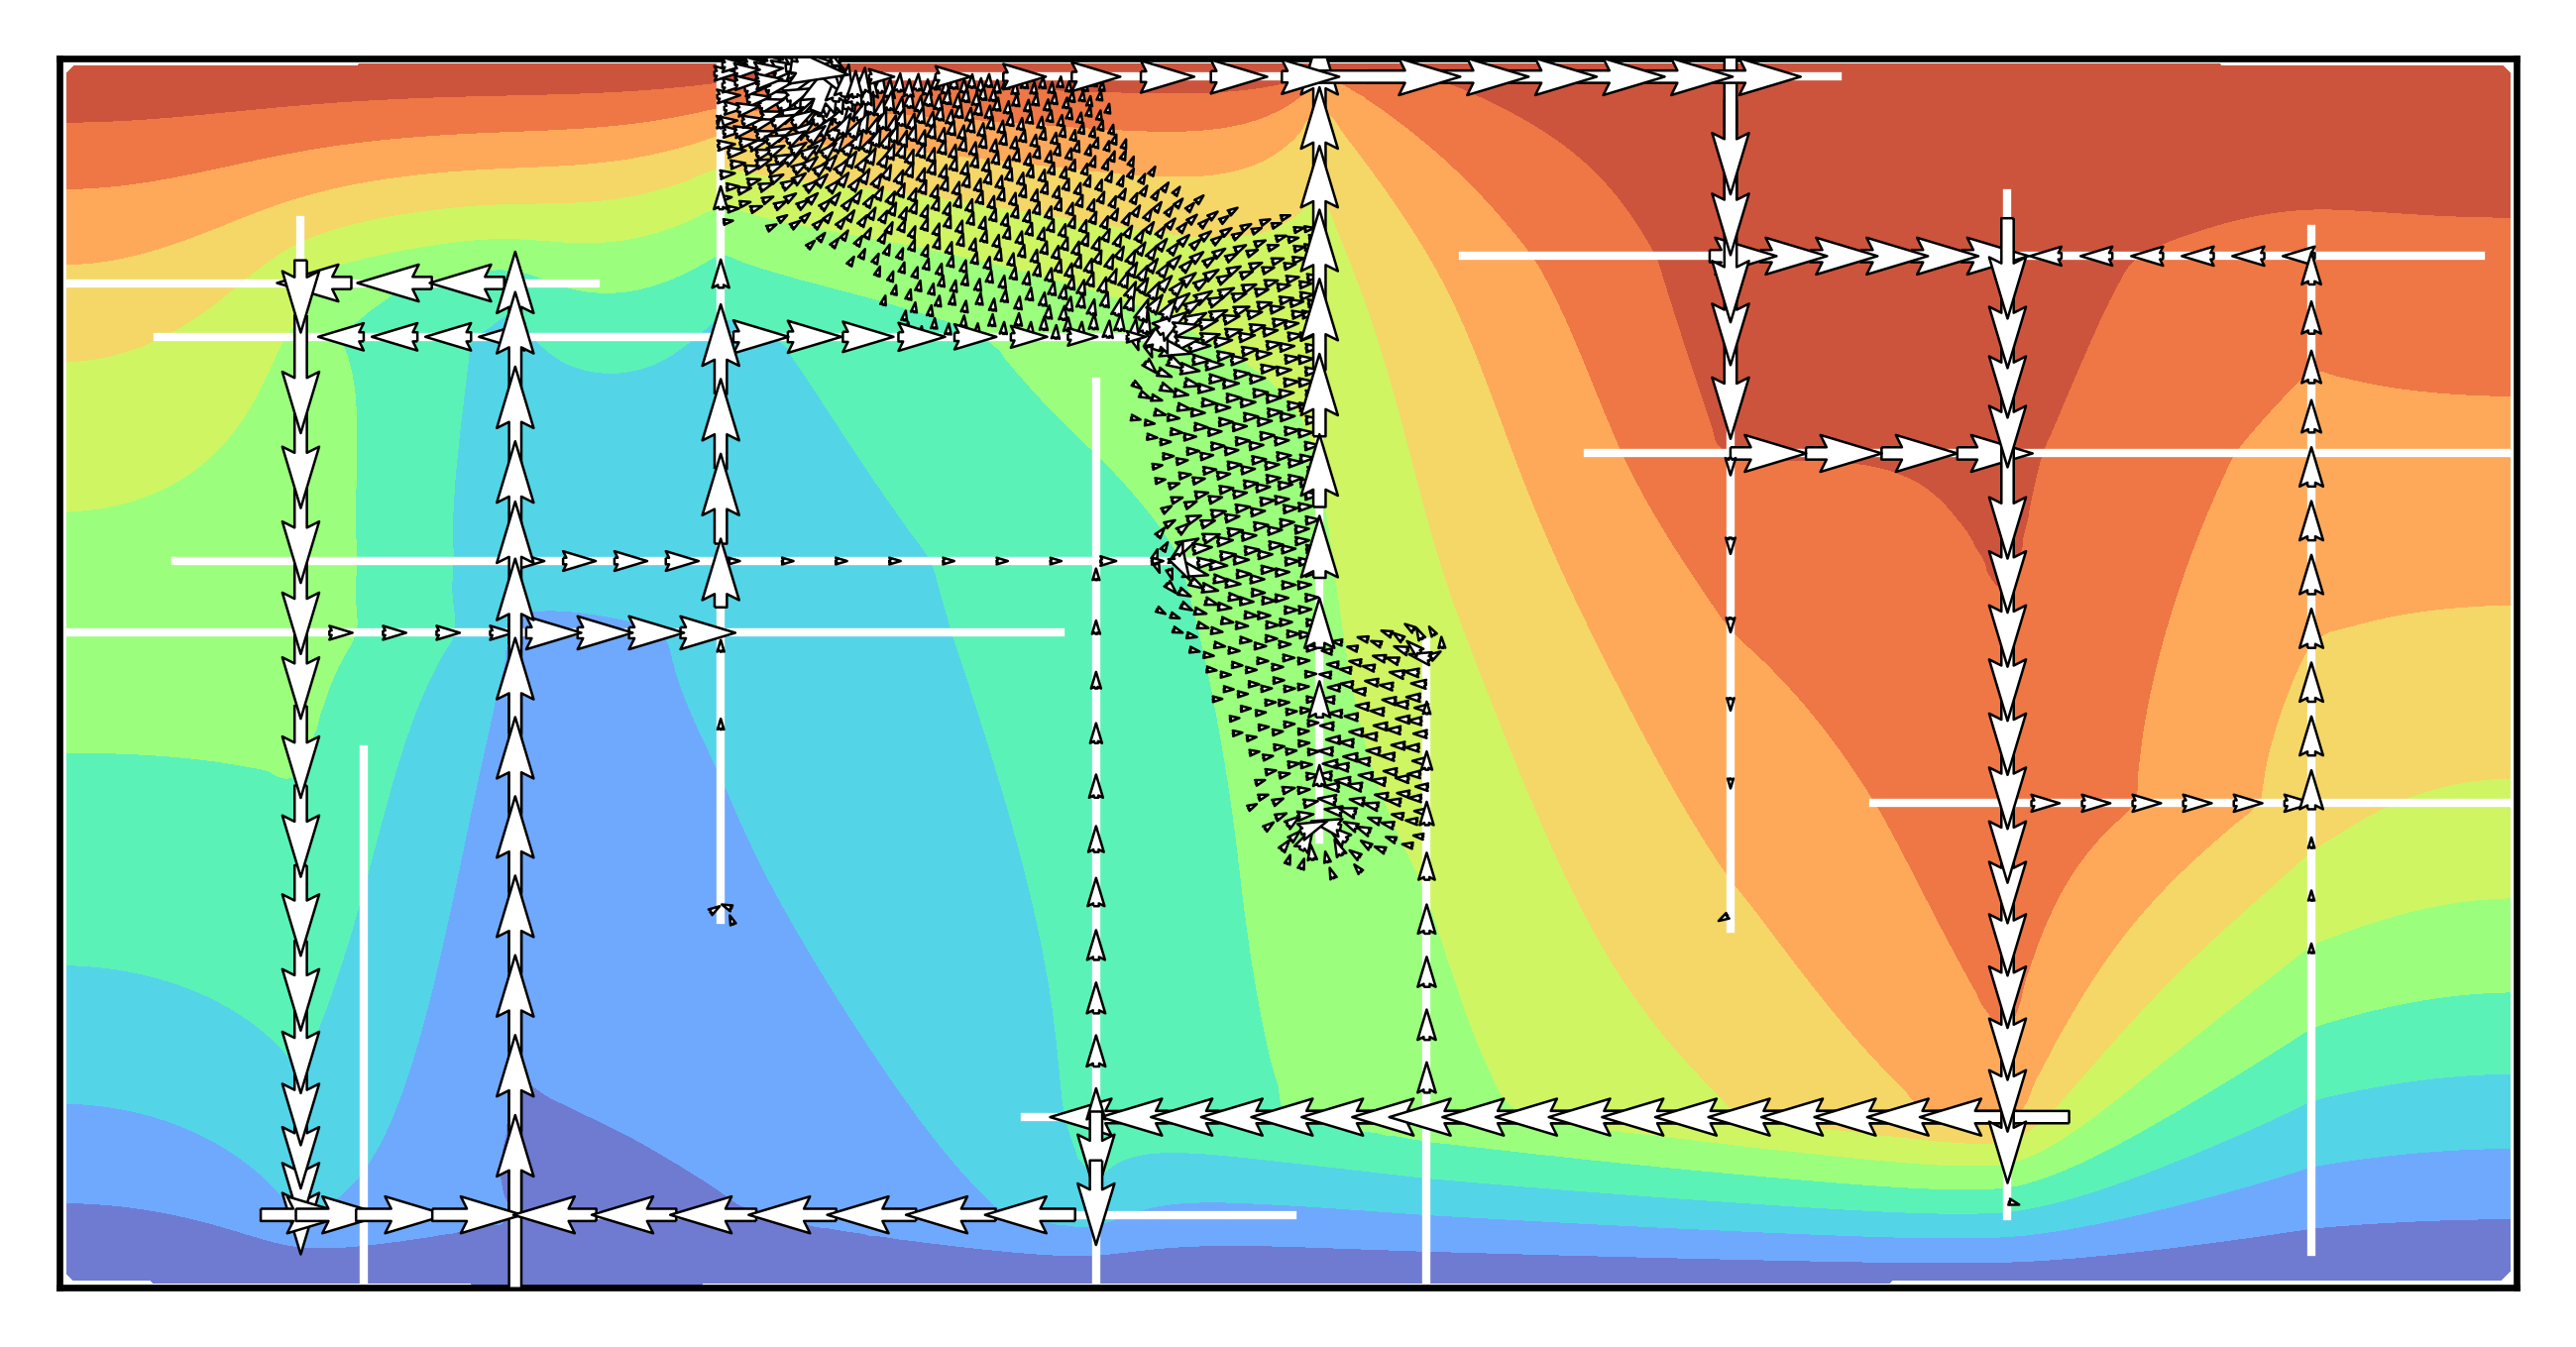

In [2]:
pb = co.pkl(dict(cartella='../simulazioni/dir_vg14', nome='E9b'))

subdomains = pb.mdg.subdomains()
sD = subdomains[0]

fig,ax = plt.subplots(figsize=(linewidth*0.8, linewidth*0.8/2))
plot_cells(pb, 'concentrazione', ax=ax, fratture_lw=1, **pc_w)

dist = co.raccogli_stato(pb.mdg, 'vu')
# for sd in subdomains:
#     if sd.dim == 2: dist[sd] *= 3
# #     if sd.dim == 1: dist[sd] *= 0.3

# xs, ys, _ = np.concatenate( [sd.cell_centers for sd in subdomains], axis=1 )

us, vs, _ = np.concatenate( [dist[sd] for sd in subdomains], axis=1 )
max_speed = np.linalg.norm( np.sqrt(us**2 + vs**2) , np.inf)

for i,sd in enumerate(subdomains):
    xs, ys, _ = sd.cell_centers
    us, vs, _ = dist[sd]
    speed = np.sqrt(us**2 + vs**2)
    soglia = 0.05
    mask = speed > soglia*max_speed
    xs = xs[mask]; ys = ys[mask]
    us = us[mask]; vs = vs[mask]
    
    salta = 1
    if sd.dim == 1 and xs.shape[0] > 0:
        estremi = np.quantile(sd.cell_centers, [0,1], axis=1)
        lunghezza = np.max(np.abs( estremi[1] - estremi[0] ))
        numero = sd.num_cells
        salta = int(numero / lunghezza * 0.6)

        dir_p = np.c_[xs[-1]-xs[0],ys[-1]-ys[0]]; dir_u = np.mean( np.c_[us,vs], axis=0 )
        if np.dot( dir_p, dir_u  ) > 0: salta *= -1
        
        xs = xs[::salta]; ys = ys[::salta]
        us = us[::salta]; vs = vs[::salta]
        
    
    ax.quiver(
        xs,ys,us,vs,
        scale_units='width', scale=1000, minlength=0.1,
        pivot='mid', width=0.005,
        facecolor='white', edgecolor='black', linewidth=0.3,
        zorder=10,
    )

fig.savefig('../immagini/E9b_vel.png', **sf_kw)

In [3]:
def condensatore(eps, l):
    _,dati = hrl.vg14('D', 1, grid_scale=0.1)
    
    def verticale(x, y1, y2): return [[x,x],[y1,y2]]
    def orizzontale(y, x1, x2): return [[x1,x2],[y,y]]
    f = [ 
        verticale(7, 3.5, 6.5), verticale(13, 3.5, 6.5),
        orizzontale(3.5, 7, 13), orizzontale(6.5, 7, 10-eps/2), orizzontale(6.5, 10+eps/2, 13) 
    ]
    if eps > 0 and l > 0: f += [ verticale(10-eps/2, 6.5-l/2, 6.5+l/2), verticale(10+eps/2, 6.5-l/2, 6.5+l/2) ]
    mdg = pp.meshing.cart_grid( np.array(f), nx=np.array([200, 100]), physdims=(20, 10) )
    return mdg, dati

In [5]:
# mdg,dati = condensatore(0.4, 2.0)
# imp = { 'nome': 'eig', 'cartella': '/home/arash/src/ddf/simulazioni/condensatore', 'parla': 4 }
# pb_eig = hrl.HRL(mdg, dati, imp)
# pb_eig.init()
# pb_eig.steady_state()
# eig = pb_eig.eig(k=2, ks=1)
# print(eig.vals)

In [6]:
# plot_cells(pb_eig, 'concentrazione', fratture_lw=1)

In [7]:
mdg,dati = condensatore(0.2, 1.6)
imp = { 'nome': 'eig', 'cartella': '/home/arash/src/ddf/simulazioni/condensatore', 'parla': 4 }
pb_eig = co.pkl(imp)
if pb_eig is None:
    pb_eig = hrl.HRL(mdg, dati, imp)
    pb_eig.init()
    pb_eig.steady_state()
    eig = pb_eig.eig(k=2)
    print(eig.vals)
    pb_eig.esporta(stato=1, pkl=1)

In [8]:
mdg,dati = condensatore(0.4, 2.0)
imp = { 
    'nome': 'dir', 'cartella': '/home/arash/src/ddf/simulazioni/condensatore', 'parla': 2,
    'esporta': 1, 'scalari_post': [ 'tempo', hrl.dizionario_post['sherwood'] ], 'campi_post': []
}
pb_dir = co.pkl(imp)
if pb_dir is None:
    pb_dir = hrl.HRL(mdg, dati, imp)
    pb_dir.init()
    pb_dir.perturba_cella()
    pb_dir.adaptive(dt_init=0.01, dt_max=1)
    pb_dir.steady_state()

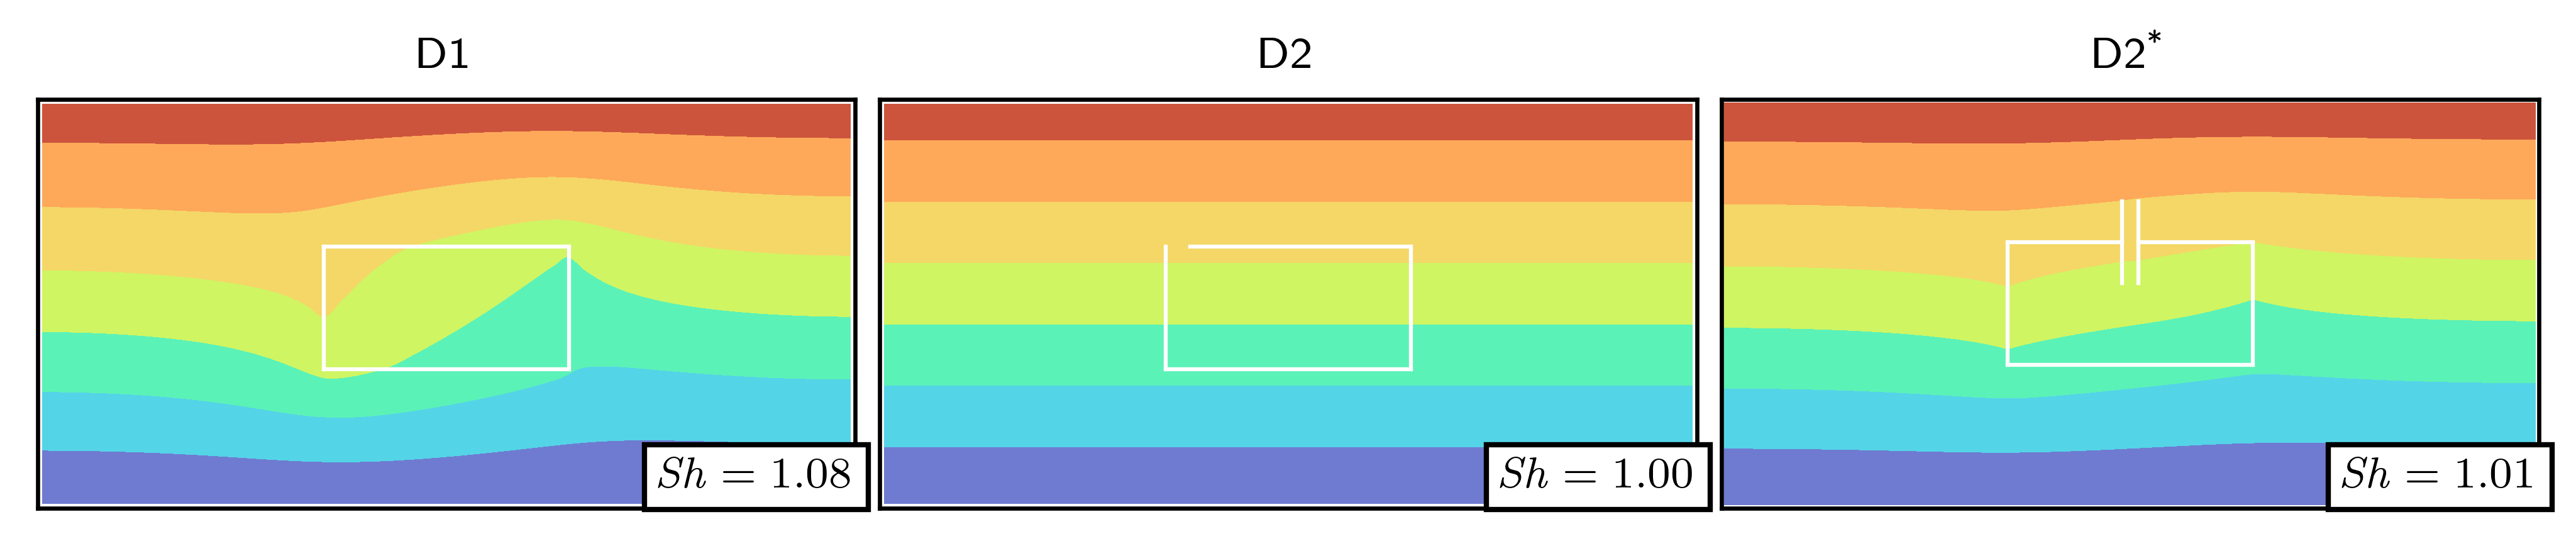

In [10]:
fig,axs = plt.subplots(1,3, figsize=(linewidth, linewidth/3/2*1.07))

kw = { 'fratture_lw': 0.5, 'method': 'cubic', 'Nx': 512, 'cmap': cmap_w }
bbox = dict(facecolor='white', boxstyle='square,pad=0.3', edgecolor='black')


d1 = co.pkl(dict(cartella='../simulazioni/dir_vg14', nome='D1'))
d2 = co.pkl(dict(cartella='../simulazioni/dir_vg14', nome='D2'))

plot_cells( d1, 'concentrazione', ax=axs[0], **kw|dict(fratture_lw=0.75))
plot_cells( d2, 'concentrazione', ax=axs[1], **kw|dict(fratture_lw=0.75))
plot_cells( pb_dir, 'concentrazione', ax=axs[2], **kw|dict(fratture_lw=0.75))

axs[0].text(20, 0.5, r'$ \mathit{Sh} = %.2f $' % d1.scalari['sherwood'][-1], fontsize='small', ha='right', bbox=bbox)
axs[1].text(20, 0.5, r'$ \mathit{Sh} = %.2f $' % d2.scalari['sherwood'][-1], fontsize='small', ha='right', bbox=bbox)
axs[2].text(20, 0.5, r'$ \mathit{Sh} = %.2f $' % pb_dir.scalari['sherwood'][-1], fontsize='small', ha='right', bbox=bbox)

axs[0].set_title('D1')
axs[1].set_title('D2')
axs[2].set_title(r'D2\textsuperscript{*}')

fig.tight_layout(pad=0.1)
fig.savefig('../immagini/condensatore.png', **sf_kw|dict(pad_inches=0.2))

In [ ]:
raise

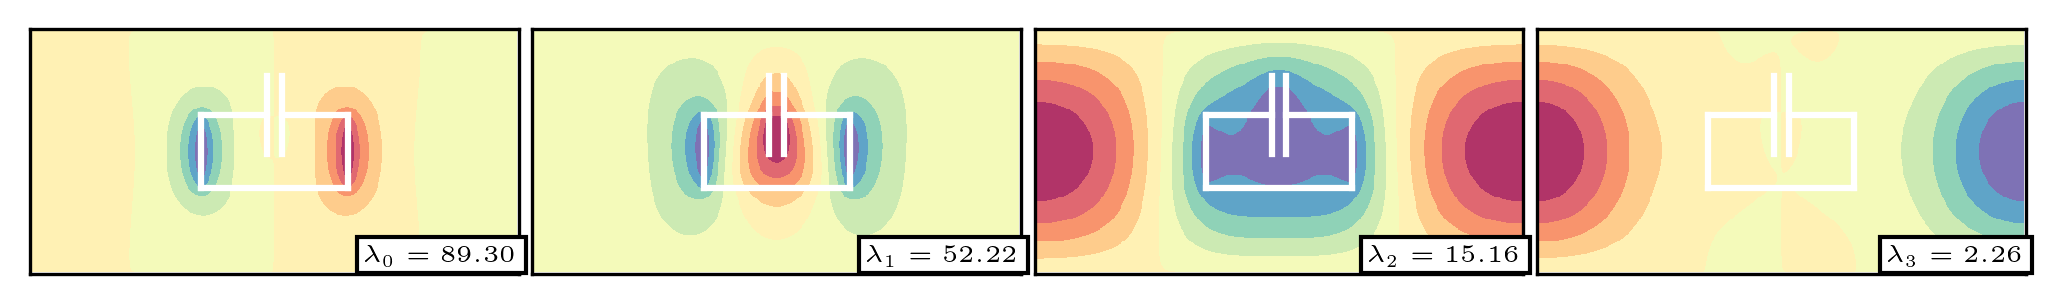

In [11]:
fig,axs = plt.subplots(1, 4, figsize=(linewidth, linewidth/4/2))
for j in range(4):
    eig = pb_eig._eig
    plot_cells(pb_eig, eig.funs[:,j], cmap=cmap_dw, ax=axs[j], method='cubic', Nx=512, fratture_lw=1.5)
    bbox = dict(facecolor='white', boxstyle='square,pad=0.3', edgecolor='lightgrey' if eig.vals[j] < 0 else 'black')
    axs[j].text(20, 0.5, r'$ \lambda_%d = %.2f $' % (j, eig.vals[j]), fontsize='xx-small', ha='right', bbox=bbox)
fig.tight_layout(pad=0.08)

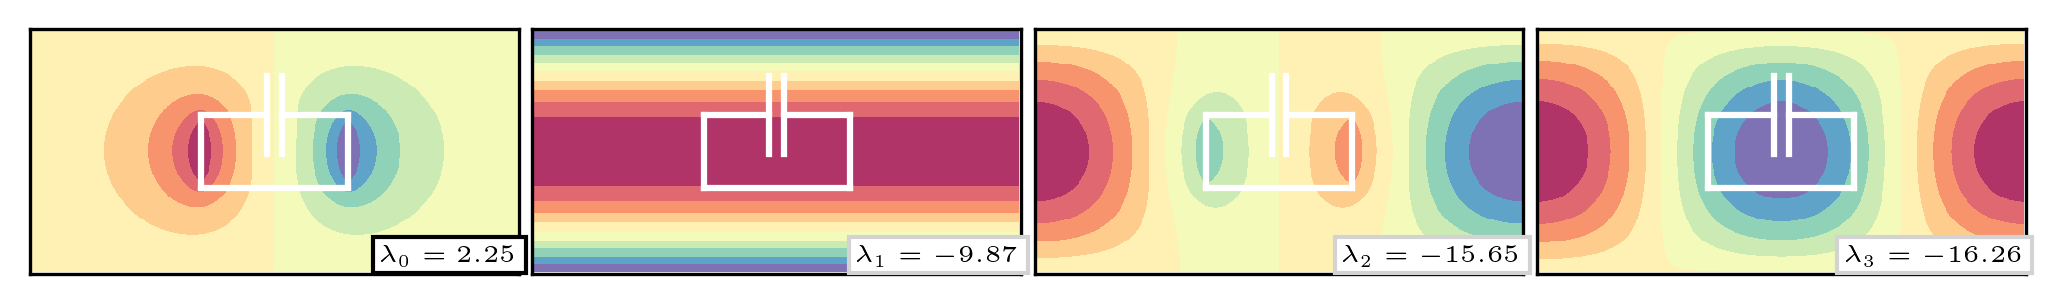

In [4]:
fig,axs = plt.subplots(1, 4, figsize=(linewidth, linewidth/4/2))
for j in range(4):
    eig = pb_eig._eig
    plot_cells(pb_eig, eig.funs[:,j], cmap=cmap_dw, ax=axs[j], method='cubic', Nx=512, fratture_lw=1.5)
    bbox = dict(facecolor='white', boxstyle='square,pad=0.3', edgecolor='lightgrey' if eig.vals[j] < 0 else 'black')
    axs[j].text(20, 0.5, r'$ \lambda_%d = %.2f $' % (j, eig.vals[j]), fontsize='xx-small', ha='right', bbox=bbox)
fig.tight_layout(pad=0.08)
fig.savefig('../immagini/condensatore_eig.png', transparent=1, bbox_inches='tight')

In [5]:
# fig,ax = plt.subplots(figsize=(linewidth*0.7, linewidth*0.7/2))
# eig = pb._eig
# j = 0
# plot_cells(pb, eig.funs[:,j], cmap=cmap_dw, ax=ax, method='cubic', Nx=512, fratture_lw=2.5)
# bbox = dict(facecolor='white', boxstyle='square,pad=0.3', edgecolor='lightgrey' if eig.vals[j] < 0 else 'black')
# ax.text(20, 0.2, r'$ \lambda_%d = %.2f $' % (j, eig.vals[j]), ha='right', bbox=bbox)

# u = co.raccogli_stato(pb.mdg, 'eig_uvel0')
# u = np.concatenate([ u[sd] for sd in pb.mdg.subdomains() ], axis=1)

# w = 8e-4
# quiver(pb, u, ax=ax, soglia=0.02, width=w, zorder=10, skip=2)
# # streamplot(pb_eig, 'eig_uvel0', ax=ax, density=4)
# fig.tight_layout(pad=0)
# # fig.savefig('immagini/p/condensatore_eig0.png', transparent=1, bbox_inches='tight')

In [6]:
mdg,dati = condensatore(0.6, 3.2)
imp = { 
    'nome': 'dir', 'cartella': '/home/arash/src/ddf/simulazioni/condensatore', 'parla': 2,
    'esporta': 1, 'scalari_post': [ 'tempo', hrl.dizionario_post['sherwood'] ], 'campi_post': []
}

pb_dir = co.pkl(imp)
if pb_dir is None:
    pb_dir = hrl.HRL(mdg, dati, imp)
    pb_dir.init()
    pb_dir.perturba_cella()
    pb_dir.adaptive(dt_init=0.01, dt_max=1)
    pb_dir.steady_state()

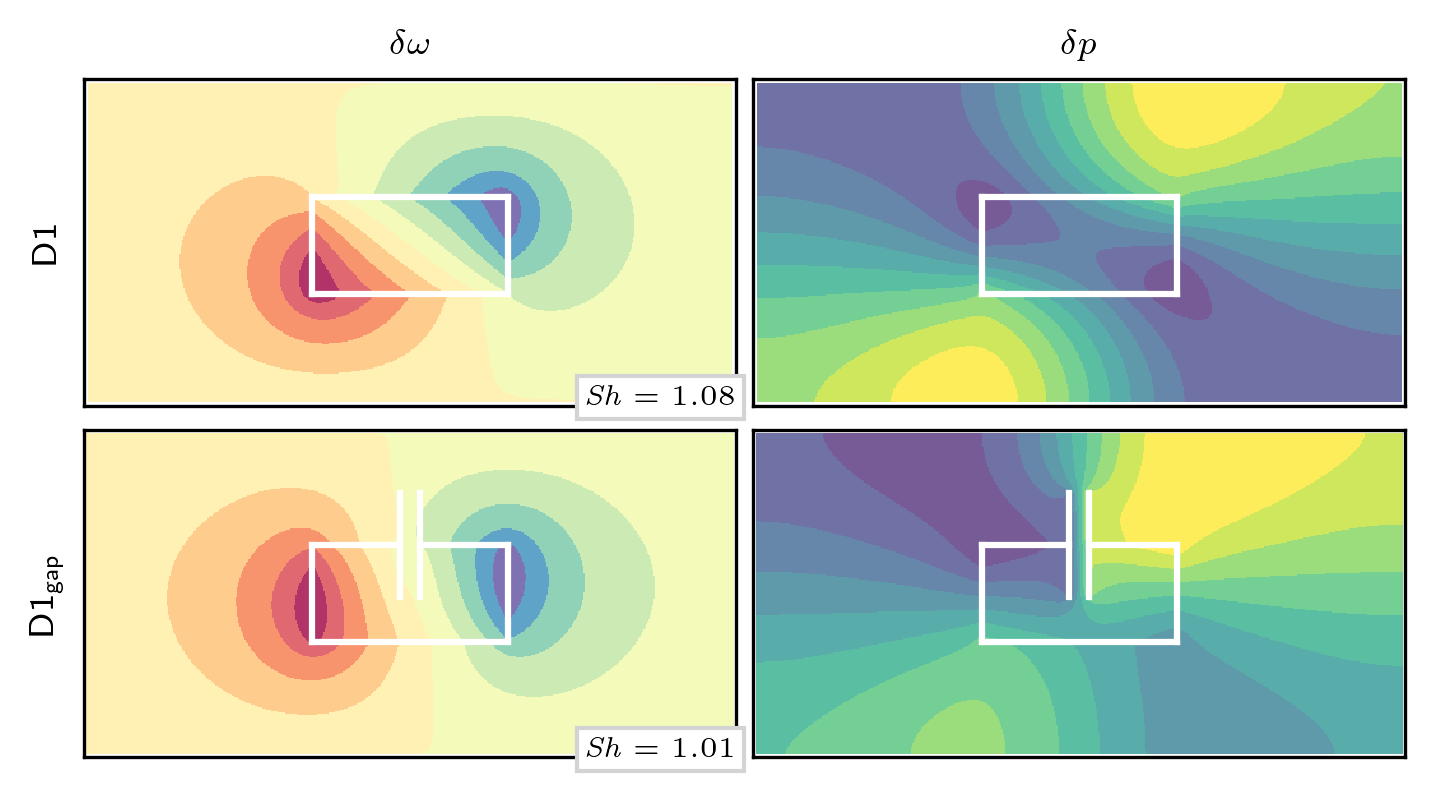

In [7]:
pb_D1 = co.pkl(dict(cartella='../simulazioni/dir_vg14', nome='D1'))

fig,axs = plt.subplots(2,2, figsize=(linewidth*0.7, linewidth*0.7/2/2*2*1.1))

sD = pb_D1.mdg.subdomains()[0]
dp = co.raccogli_stato(pb_D1.mdg, 'pressione', sD) - pb_D1.condizioni_iniziali_sd(sD)['pressione']
dw = co.raccogli_stato(pb_D1.mdg, 'concentrazione', sD) - pb_D1.condizioni_iniziali_sd(sD)['concentrazione']
plot_cells(pb_D1, dw, cmap=cmap_dw, fratture_lw=1.5, method='cubic', Nx=512, ax=axs[0,0])
plot_cells(pb_D1, dp, cmap=cmap_p, fratture_lw=1.5, method='cubic', Nx=512, ax=axs[0,1])
axs[0,0].set_ylabel('D1', fontsize='small', labelpad=5)
axs[0,0].set_title(r'$ \delta\omega $', fontsize='small')
axs[0,1].set_title(r'$ \delta p $', fontsize='small')
axs[0,0].text(20, 0, r'$ \mathit{Sh} = %.2f $' % pb_D1.scalari['sherwood'][-1], fontsize='x-small', ha='right', bbox=bbox)

sD = pb_dir.mdg.subdomains()[0]
dp = co.raccogli_stato(pb_dir.mdg, 'pressione', sD) - pb_dir.condizioni_iniziali_sd(sD)['pressione']
dw = co.raccogli_stato(pb_dir.mdg, 'concentrazione', sD) - pb_dir.condizioni_iniziali_sd(sD)['concentrazione']
plot_cells(pb_dir, dw, cmap=cmap_dw, fratture_lw=1.5, method='cubic', Nx=512, ax=axs[1,0])
plot_cells(pb_dir, dp, cmap=cmap_p, fratture_lw=1.5, method='cubic', Nx=512, ax=axs[1,1])
axs[1,0].set_ylabel(r'D1\textsubscript{gap}', fontsize='small', labelpad=5)
axs[1,0].text(20, 0, r'$ \mathit{Sh} = %.2f $' % pb_dir.scalari['sherwood'][-1], fontsize='x-small', ha='right', bbox=bbox)

fig.tight_layout(pad=0.4)
fig.savefig('../immagini/condensatore.png', transparent=1, bbox_inches='tight')

<Axes: >

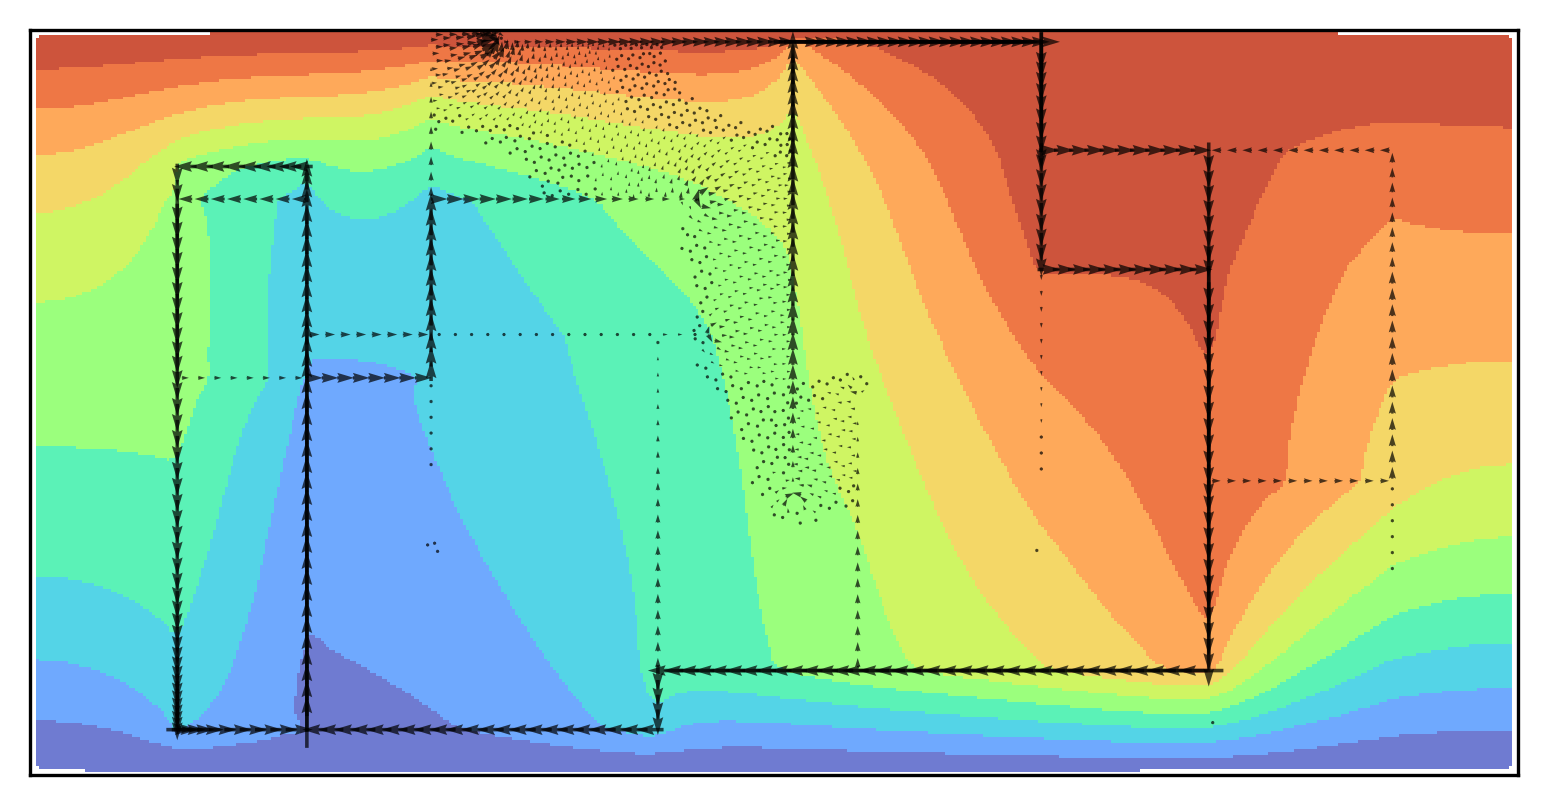

In [8]:
mdg,dati = hrl.vg14('E', '9bu')
imp = dict(
    cartella='../simulazioni/condensatore', nome='E9bu',
    parla=2, scalari_post=[ hrl.dizionario_post['sherwood'] ], esporta=1
)
pb_E = co.pkl(imp)
if pb_E is None:
    pb_E = hrl.HRL(mdg, dati, imp)
    pb_E.init()
    pb_E.steady_state()
    pb_E.perturba_cella()
    pb_E.adaptive(dt_init=0.001, dt_max=0.05)
    pb_E.steady_state()

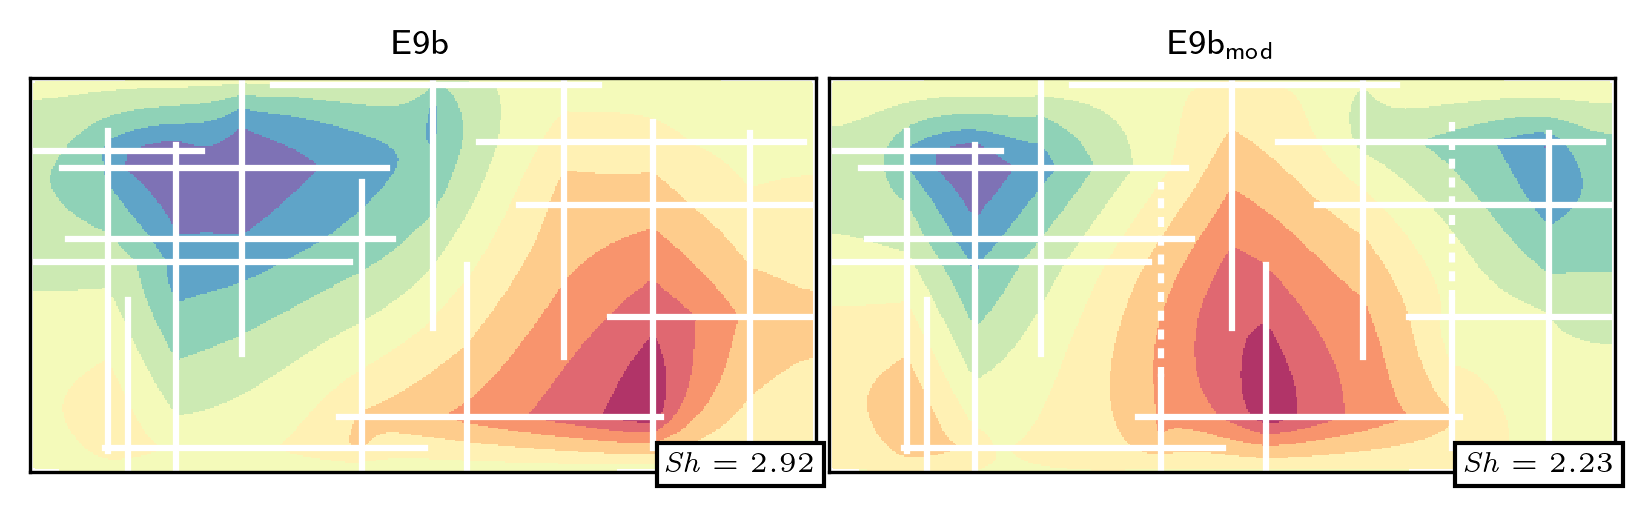

In [23]:
fig,axs = plt.subplots(1,2,figsize=(linewidth*0.8, linewidth*0.8/2/2*1.1))

ax = axs[0]
pb_E9b = co.pkl(dict(cartella='../simulazioni/dir_vg14', nome='E9b'))
sD = pb_E9b.mdg.subdomains()[0]
dw = co.raccogli_stato(pb_E9b.mdg, 'concentrazione', sD) - pb_E9b.condizioni_iniziali_sd(sD)['concentrazione']
plot_cells(pb_E9b, dw, cmap=cmap_dw, fratture_lw=1.5, method='cubic', Nx=512, ax=ax)
ax.text(20, 0, r'$ \mathit{Sh} = %.2f $' % pb_E9b.scalari['sherwood'][-1], fontsize='x-small', ha='right', bbox=bbox)
ax.set_title('E9b', fontsize='small')

ax = axs[1]
sD = pb_E.mdg.subdomains()[0]
dw = co.raccogli_stato(pb_E.mdg, 'concentrazione', sD) - pb_E.condizioni_iniziali_sd(sD)['concentrazione']
plot_cells(pb_E, dw, cmap=cmap_dw, fratture_lw=1.5, method='cubic', Nx=512, ax=ax)
X, Y = 27.5, 13.7
ax.plot(20/X*np.array([11.6, 11.6]), 10/Y*np.array([3.3, 10.1]), c='white', linestyle='dashed', dashes=(1.6,1.4), linewidth=1.5)
ax.plot(20/X*np.array([21.8, 21.8]), 10/Y*np.array([6.0, 12.2]), c='white', linestyle='dashed', dashes=(1.6,1.4), linewidth=1.5)
bbox = dict(facecolor='white', boxstyle='square,pad=0.3', edgecolor='black')
ax.text(20, 0, r'$ \mathit{Sh} = %.2f $' % pb_E.scalari['sherwood'][-1], fontsize='x-small', ha='right', bbox=bbox)
ax.set_title(r'E9b\textsubscript{mod}', fontsize='small')

fig.tight_layout(pad=0.3)
# plot_cells(pb, 'concentrazione', cmap=cmap_dw, fratture_lw=1.5, method='cubic', Nx=512, ax=ax)
fig.savefig('../immagini/condensatore_E9bu.png', transparent=1, bbox_inches='tight')

In [ ]:
# imp = dict(cartella='../simulazioni/dir_vg14', nome='E9b')
# pb = co.pkl(imp)

In [23]:
# imp = dict(cartella='../simulazioni/dir_vg14', nome='E9b')
# pb = co.pkl(imp)

# fig,ax = plt.subplots()
# plot_cells(pb, 'concentrazione', cmap=cmap_w, fratture_lw=1.5, method='cubic', ax=ax)
# quiver(pb, 'vu', ax=ax, zorder=10, color='k', scale=2e3)
# # streamplot(pb, 'vu', density=3, ax=ax)
# fig.savefig('../immagini/E9b_vel.png', transparent=1, bbox_inches='tight')